This notebook was made to compare more drifter-model results, with new river channel, reduced viscosty, no_banks and reduced viscosity&old river.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime as dt
import pytz, datetime
import arrow
import os
from IPython.core.display import Image
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [3]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
nc_tools.show_variables(tracersT)
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']
nc_tools.timestamp(tracersT, 0)

[u'deptht', u'nav_lat', u'nav_lon', u'rain_rate', u'snow_rate', u'sossheig', u'time_counter', u'time_counter_bnds', u'vosaline', u'votemper']


<Arrow [2014-10-08T00:30:00+00:00]>

In [4]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))
    viz_tools.plot_coastline(axs[0,0],grid,coords='map')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=20,color='OrangeRed')
    axs[0,0].set_xlim([-123.6,-123])
    axs[0,0].set_ylim([48.8,49.4])
    axs[0,0].set_xticks([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xlabel('Longitude')
    axs[0,0].set_ylabel('Latitude')
    
    colors=['g','DodgerBlue','tomato','Olive']
    for i, key in enumerate(lon.keys()):
        axs[0,0].scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs[0,0].scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs[0,0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    #axs[0,0].legend(loc='upper left')
    #box = axs[0,0].get_position()
    #axs[0,0].set_position([box.x0, box.y0 + box.height * 0.1,
                 #box.width, box.height * 0.9])
    axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)
    
    axs[0,1].plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    axs[0,1].set_xticklabels([])
    axs[0,1].set_ylabel('Water level (m)')
    axs[0,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[0,1].set_title('sossheig, ~Point Atkinson')
        
    t=hour
    axs[0,1].plot([timesteps[t],timesteps[t]],[-2.0,1.5],'r-',label='start')
    
    t2=hour+duration
    axs[0,1].plot([timesteps[t2],timesteps[t2]],[-2.0,1.5],'b-',label='end')
    
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)   
    #fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 5))
    axs[1,0].plot(time,wind_speed,'-k')
    axs[1,0].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,0].set_xticklabels([])
    axs[1,0].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,0].set_ylabel('Wind Speed (m/s)')
    axs[1,0].set_title('Sandheads')
    
    diff = 24 - hour
    hour2 = duration - diff
    day2 = day +1
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,0].plot([t,t],[0,10],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,0].plot([tt,tt],[0,10],'b-',label='end')
    axs[1,0].legend(loc='upper left')

    axs[1,1].plot(time,wind_dir,'-k')
    axs[1,1].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,1].set_xticklabels([])
    axs[1,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,1].set_ylabel('Wind Direction (deg CCW of E)')
    axs[1,1].set_title('Sandheads')
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,1].plot([t,t],[0,350],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,1].plot([tt,tt],[0,350],'b-',label='end')
    axs[1,1].legend(loc='upper left')
    return fig

In [5]:
directories = ['oct8_10RFdailySmoo', 'oct8_10reduceviscosity','oct8_101e061e05','4-10oct14']
bases = ['/data/jieliu/MEOPAR/river-treatment/','/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/']
sfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_T.nc','{}/SalishSea_1h_20141004_20141010_grid_T.nc']
ufile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_U.nc','{}/SalishSea_1h_20141004_20141010_grid_U.nc']
vfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_V.nc', '{}/SalishSea_1h_20141004_20141010_grid_V.nc']
Ss={};Us={};Vs={};depths={};
##load non-nowcasts results
for directory in directories: 
    if directory == directories[-1]:
        path = os.path.join(bases[1],sfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht'] 
        path = os.path.join(bases[1],ufile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[1],vfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']
    else:
        print('non-nowcast')
        path = os.path.join(bases[0],sfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht']
        path = os.path.join(bases[0],ufile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[0],vfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']   

non-nowcast
non-nowcast
non-nowcast


In [6]:
def plot_salinity_uv(j,i,t, zmin,zmax):
    """This function was made to plot salinity, u, v profiles at the
       released position.    """
    fig, axs =plt.subplots(1,3, figsize = (15,6))
    colors=['g','Olive','DodgerBlue','tomato']
    ##salinity profiles
    ax = axs[0]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Ss[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Ss[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('Practical Salinity')
    ax.set_xlim([0,32])
    ##U profiles
    ax = axs[1]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Us[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Us[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('U velocity [m/s]')
    ax.set_xlim([-0.5,0.5])
    ##V profiles
    ax = axs[2]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Vs[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Vs[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('V velocity [m/s]')
    ax.set_xlim([-0.5,0.5])
    for ax in axs:
        ax.legend(loc=0)
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    return fig

# Comparison with extended and deepened river channel

* Oct8 drop1

In [7]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['new']=o112.variables['traj_lon']
lat112['new']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['reduce_viscosity']=o112.variables['traj_lon']
lat112['reduce_viscosity']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['reduce_vis&diff']=o112.variables['traj_lon']
lat112['reduce_vis&diff']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['old']=o112.variables['traj_lon']
lat112['old']=o112.variables['traj_lat']

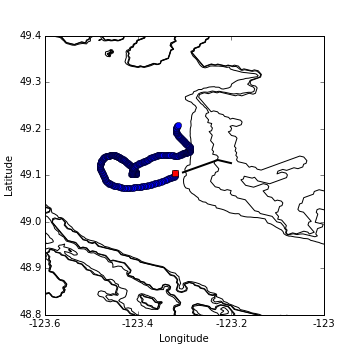

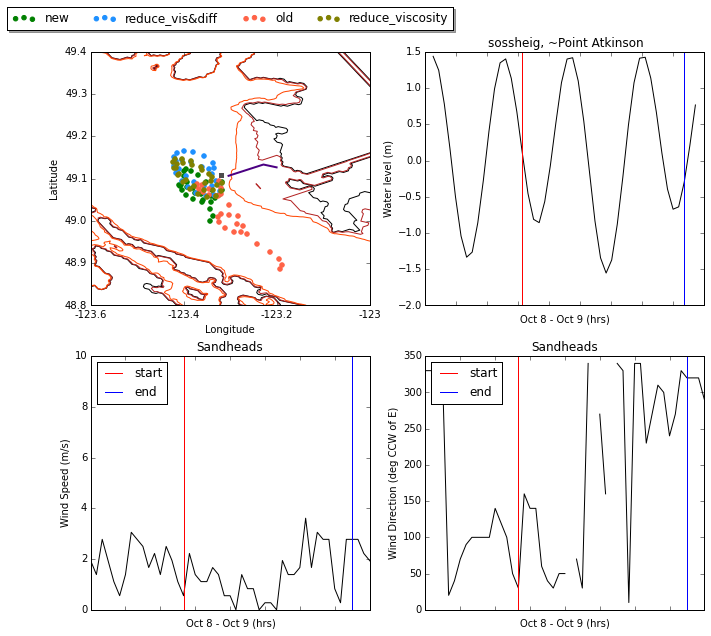

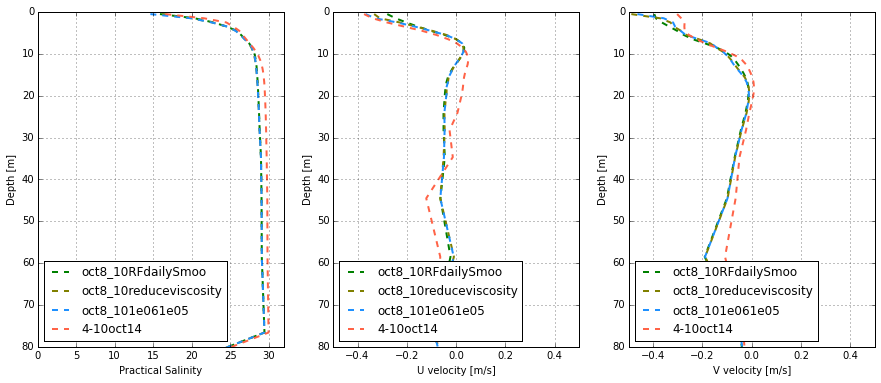

In [8]:
## python grid point (429, 290) 
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
fig = plot_salinity_uv(429,290, 16,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop112a.png')

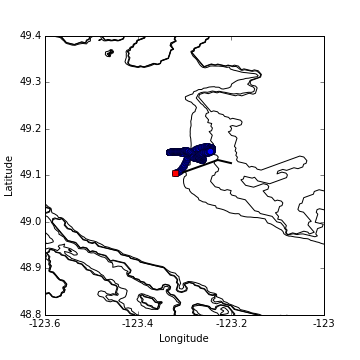

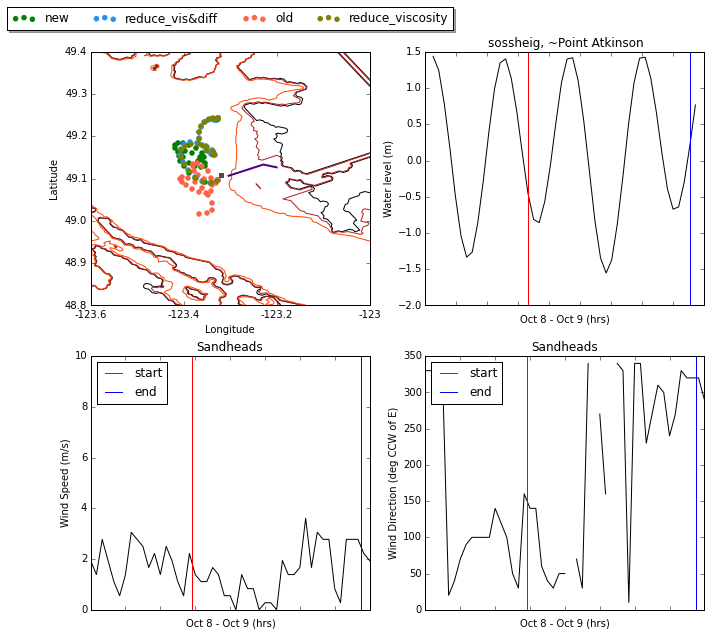

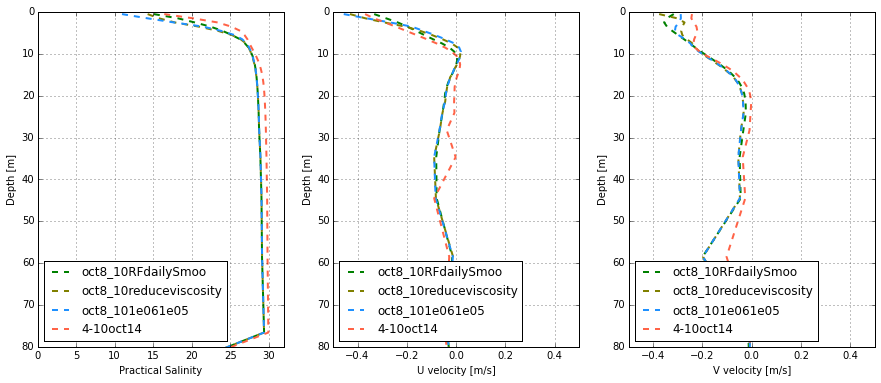

In [9]:
## python grid point (429,290) at 17:30 for 29hrs
fig=plotoct_mewold(lon112,lat112,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,29)
fig = plot_salinity_uv(429,290, 17,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop112b.png')

In [10]:
lon13={};lat13={}
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['new']=o13.variables['traj_lon']
lat13['new']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['reduce_viscosity']=o13.variables['traj_lon']
lat13['reduce_viscosity']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['reduce_vis&diff']=o13.variables['traj_lon']
lat13['reduce_vis&diff']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['old']=o13.variables['traj_lon']
lat13['old']=o13.variables['traj_lat']

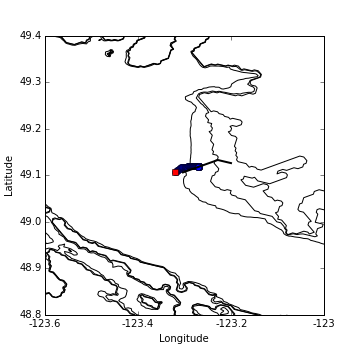

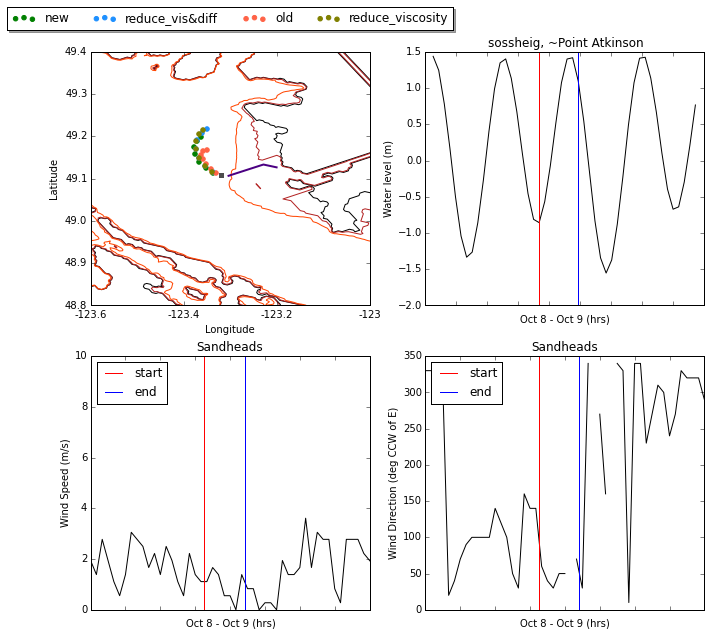

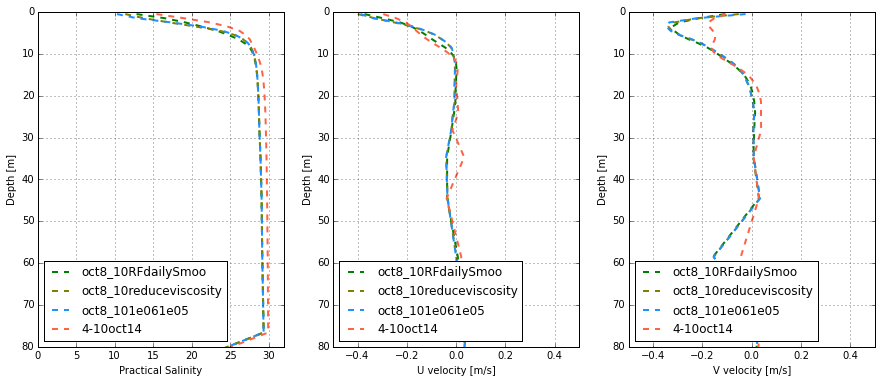

In [11]:
## python grid point (429,290) at 19:30 for 7hrs
fig=plotoct_mewold(lon13,lat13,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,30,7)
fig = plot_salinity_uv(429,290, 18,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop13.png')

* Oct8 drop2

In [12]:
lon212={};lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['new']=o212.variables['traj_lon']
lat212['new']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['reduce_viscosity']=o212.variables['traj_lon']
lat212['reduce_viscosity']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['reduce_vis&diff']=o212.variables['traj_lon']
lat212['reduce_vis&diff']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['old']=o212.variables['traj_lon']
lat212['old']=o212.variables['traj_lat']

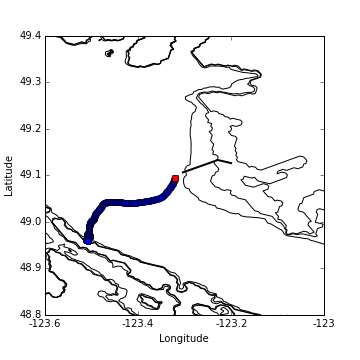

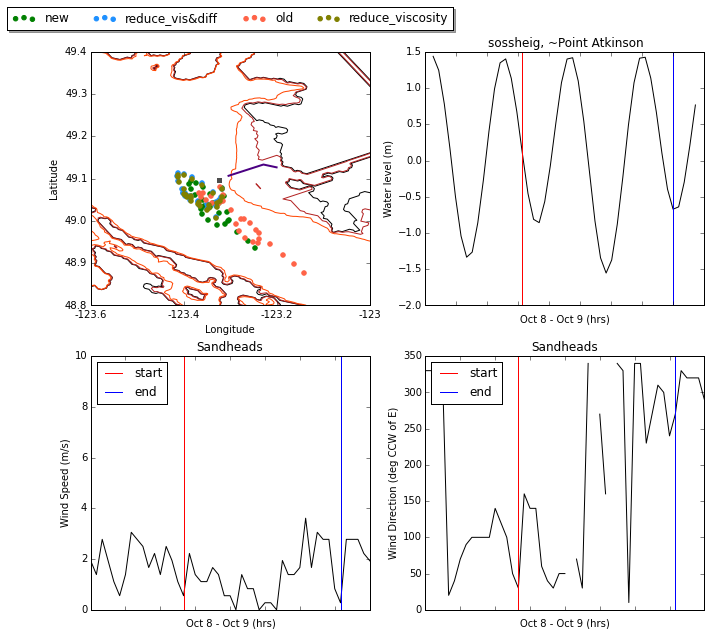

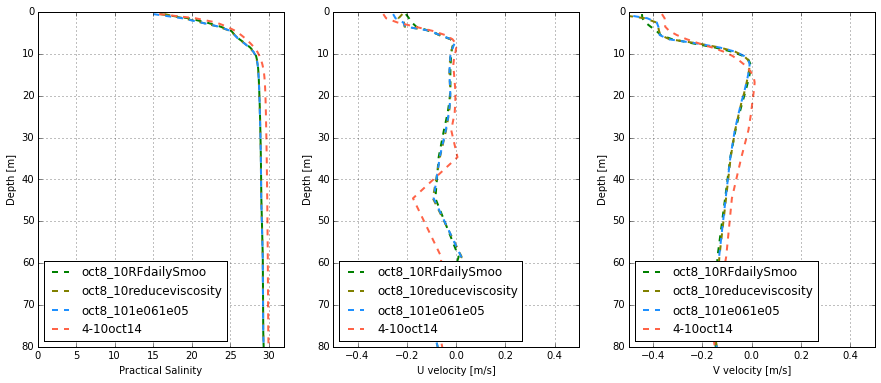

In [13]:
## python grid point (427,288) at 16:00 for 27hrs
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(427,288, 16,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop212a.png')

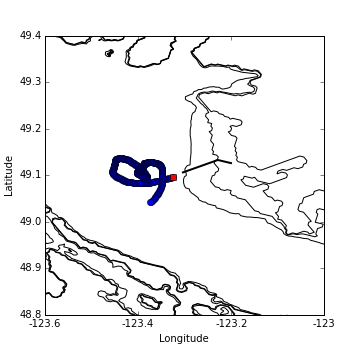

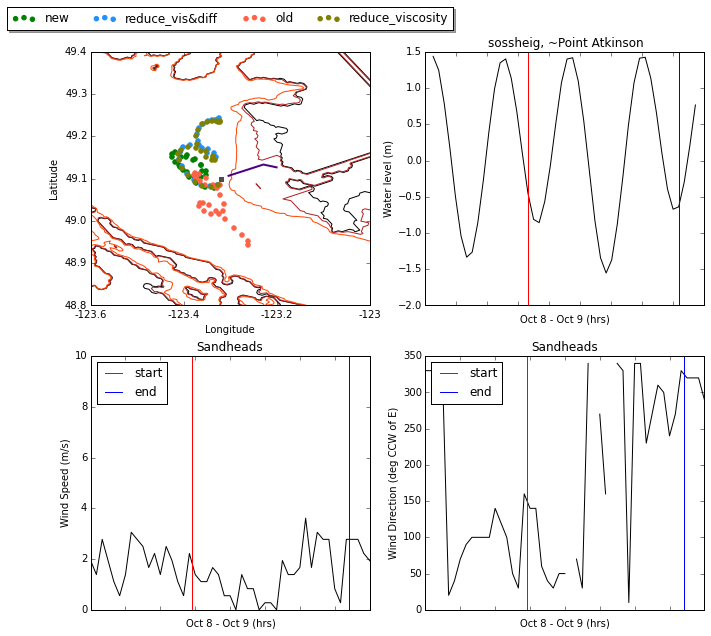

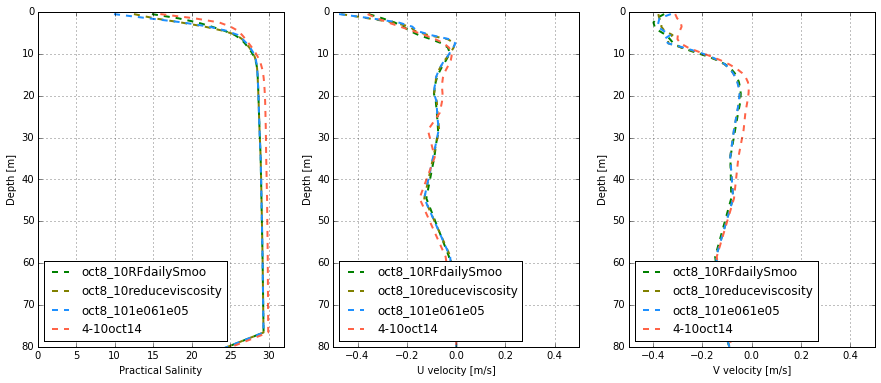

In [14]:
## python grid point (427,289) at 17:30 for 27hrs
fig = plotoct_mewold(lon212,lat212,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,27)
fig = plot_salinity_uv(427,289, 17,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop212b.png')

In [15]:
lon23={};lat23={}
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['new']=o23.variables['traj_lon']
lat23['new']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['reduce_viscosity']=o23.variables['traj_lon']
lat23['reduce_viscosity']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['reduce_vis&diff']=o23.variables['traj_lon']
lat23['reduce_vis&diff']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['old']=o23.variables['traj_lon']
lat23['old']=o23.variables['traj_lat']

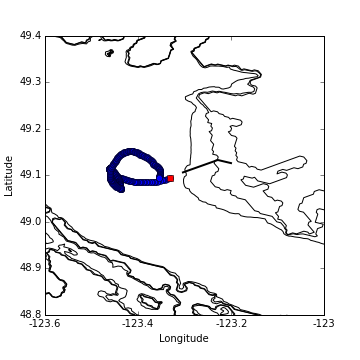

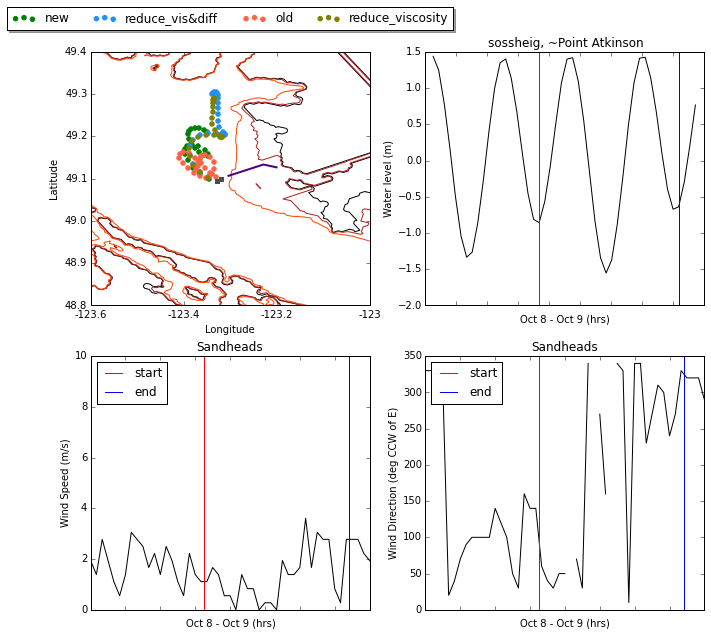

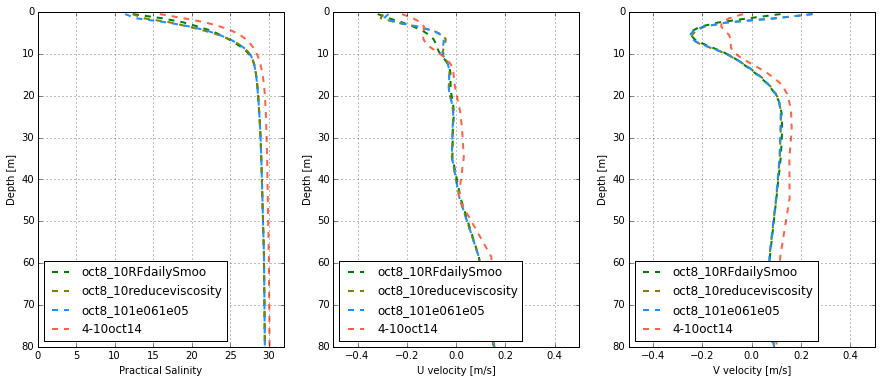

In [16]:
## python grid point (427,287) at 19:30 for 25hrs
fig = plotoct_mewold(lon23,lat23,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,30,25)
fig = plot_salinity_uv(427,287, 19,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop23.png')

* Oct drop3

In [17]:
lon31={};lat31={}
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['new']=o31.variables['traj_lon']
lat31['new']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['reduce_viscosity']=o31.variables['traj_lon']
lat31['reduce_viscosity']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['reduce_vis&diff']=o31.variables['traj_lon']
lat31['reduce_vis&diff']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['old']=o31.variables['traj_lon']
lat31['old']=o31.variables['traj_lat']

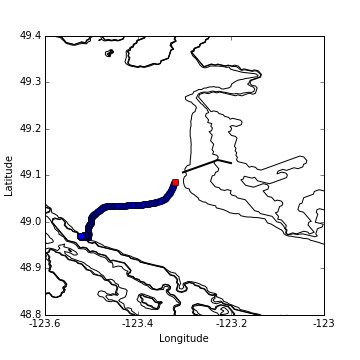

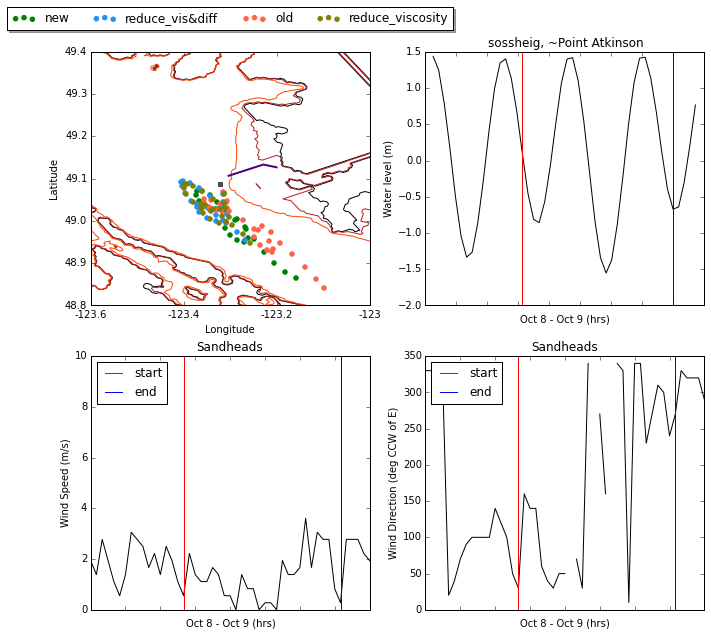

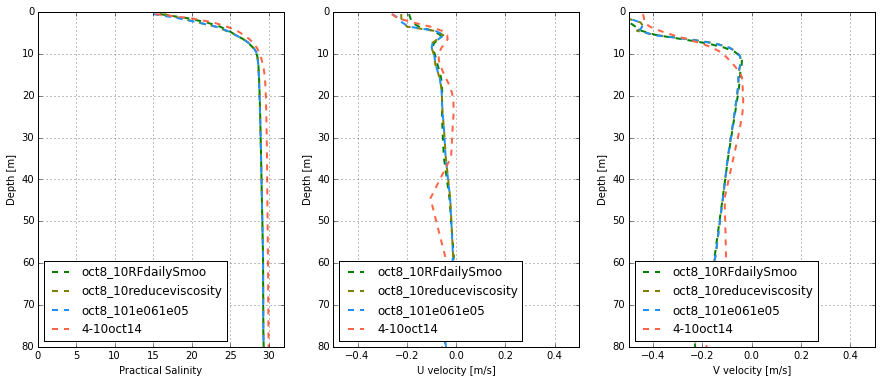

In [18]:
## python grid point (425,287) at 16:00 for 27hrs
fig = plotoct_mewold(lon31,lat31,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(425,287, 16,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop31.png')

In [19]:
lon323={};lat323={}
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['new']=o323.variables['traj_lon']
lat323['new']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['reduce_viscosity']=o323.variables['traj_lon']
lat323['reduce_viscosity']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['reduce_vis&diff']=o323.variables['traj_lon']
lat323['reduce_vis&diff']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['old']=o323.variables['traj_lon']
lat323['old']=o323.variables['traj_lat']

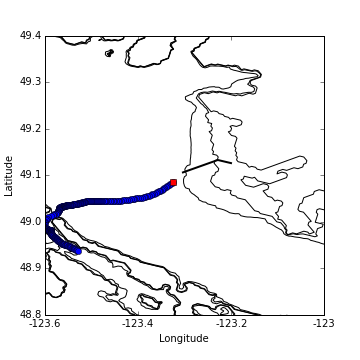

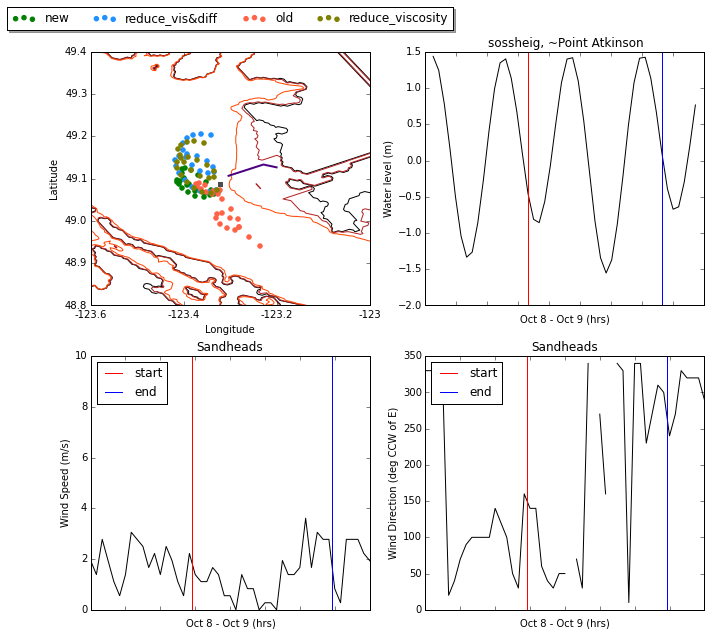

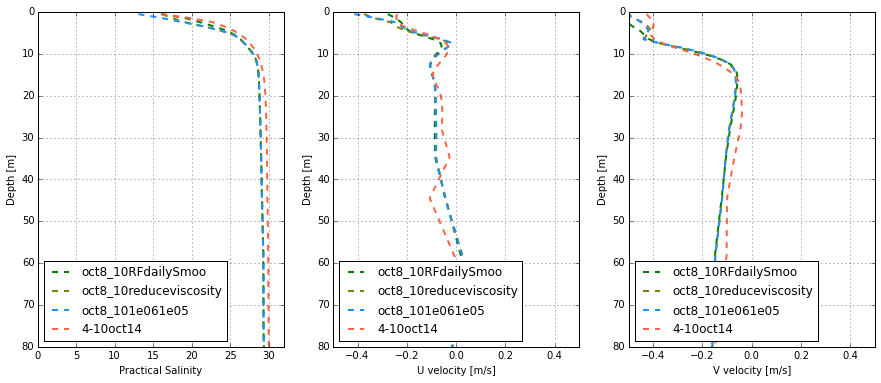

In [20]:
## python grid point (425,287) at 17:30 for 24hrs
fig = plotoct_mewold(lon323,lat323,0,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,24)
fig = plot_salinity_uv(425,287, 17,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop323a.png')

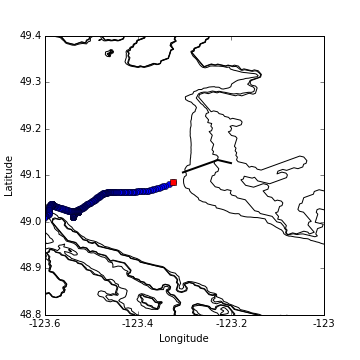

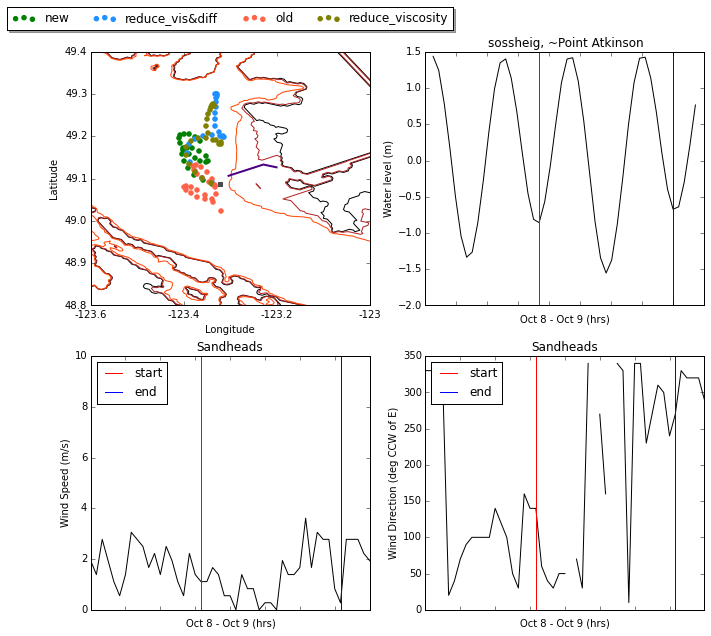

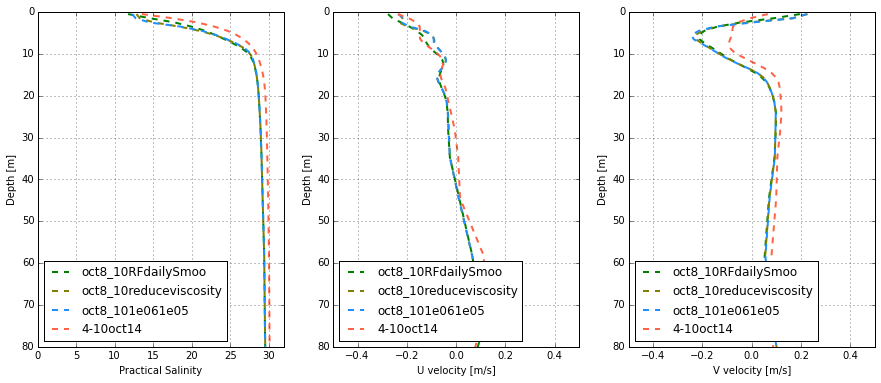

In [21]:
## python grid point (425,287) at 19:00 for 24hrs
fig = plotoct_mewold(lon323,lat323,1,'7-Oct-2014','11-Oct-2014',8,10,8,19,0,24)
fig = plot_salinity_uv(425,287, 19,0, 80)
Image(filename='/ocean/jieliu/research/meopar/surface current/drop323b.png')

* Overall, results with new river treatments are better than nowcasts except drop23. But the problem with new river is we have too much plume going northward! Does it due to lack of jetty?

* 